# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

from functools import partial

# 2/ The Active Inference package 
import actynf
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog

# 3/ Tools for : 
# a. Getting the raw data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
# b. Preprocessing the data :
from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data



# We define the environment as a state machine that outputs a feedback 
# every time an action is given to it : 
from actynf.jaxtynf.layer_process import initial_state_and_obs,process_update
from actynf.jaxtynf.shape_tools import vectorize_weights


# The environment is statically defined by its HMM matrices : 
from hmm_weights import behavioural_process

# For the active inference model : 
from hmm_weights import basic_latent_model

from actynf.jaxtynf.layer_trial import compute_step_posteriors
from actynf.jaxtynf.layer_learn import learn_after_trial
from actynf.jaxtynf.layer_options import get_learning_options,get_planning_options

from actynf.jaxtynf.shape_tools import to_log_space,get_vectorized_novelty




c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Now to the models ! 
# Let us grab a model of the training environment itself : 

class TrainingEnvironment :
    def __init__(self,rng_key,a,b,c,d,e,u,T):
        # Environment parameters
        self.a = a
        self.b = b
        self.c = c 
        self.d = d
        self.e = e
        self.u = u
        
        # Timing
        self.Ntimesteps = T
        self.t = 0
        self.rng_key = rng_key
        
        # Inner state and last feedback
        self.current_state = None
        self.previous_observation = None
        
        self.update_vectorized_weights()
    
    def update_vectorized_weights(self):
        self.vec_a,self.vec_b,self.vec_d = vectorize_weights(self.a,self.b,self.d,self.u)
    
    def reinit_trial(self):
        self.t = 0
        
        self.rng_key,init_tmstp_key = jax.random.split(self.rng_key)
        [s_d,s_idx,s_vect],[o_d,o_idx,o_vect] = initial_state_and_obs(init_tmstp_key,self.vec_a,self.vec_d)
        
        self.current_state = s_vect
        self.previous_observation = o_vect
        
        return o_vect,jnp.array(0.0),False,self.t
    
    def step(self,action_chosen):
        self.t = self.t + 1   # New timestep !
        
        if self.t == self.Ntimesteps: # This should not happen as we check below :
            print("New trial ! The action has not been used here.")
            return self.reinit_trial()
        
        self.rng_key,timestep_rngkey = jax.random.split(self.rng_key)
        [s_d,s_idx,s_vect],[o_d,o_idx,o_vect] = process_update(timestep_rngkey,self.current_state,self.vec_a,self.vec_b,action_chosen)
        
        
        N_outcomes = o_vect[0].shape[0]
        reward = (jnp.linspace(0,1,N_outcomes)*(o_vect[0] - self.previous_observation[0])).sum()
        
        
        # The next timestep for the agent :
        
        self.current_state = s_vect
        self.previous_observation = o_vect
         
        return o_vect,reward,(self.t == self.Ntimesteps-1),self.t



In [3]:
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
env = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)
    
for k in range(10):
    print("----Trial {}----".format(k))
    o,r,end_trial,t = env.reinit_trial()
    print(t,o,r)
    while not(end_trial) :
        o,r,end_trial,t = env.step(jax.nn.one_hot(1,9))
        print(t,o,r)
    print("----")
        

----Trial 0----
0 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
2 [Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)] 0.22222224
3 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.22222224
4 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.11111112
5 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.11111112
6 [Array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)] 0.111111104
7 [Array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
8 [Array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] -0.33333334
9 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.22222224
10 [Array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)] 0.111111104
----
----Trial 1----
0 [Array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)] 0.0
1 [Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]

To put all the models we are going to fit in an equal footing, we will assume a discretized action space along the 3 dimensions previously mentionned for all of them. To study the effect of not making this crucial hypothesis, we refer the reader to the Reinforcment Learning part of this study. 

Reward definition : we will assume that agents perceive changes in the level of the gauge as a reward signal.

Here, we will study the following models : 
### Blind models - the action does not depend on the stimuli at all
1. A random action model that selects actions randomly and does not learn
2. A choice kernel model that repeats actions it already performed :  $CK_{t+1}(u) = CK_{t}(u) + \alpha_c (a_t - CK_{t}(u))$ where $a_t$ is 1 if $u$ was selcted and 0.0 otherwise. $P_t(u) = \sigma(\beta_c CK_{t})$
### Stateless models - the action does not depend on the level of the gauge but only on the reward
3. A Rescorla-Wagner model - stateless that attempts to learn the value of a specific action by updating the perceived reward attached to it : $Q_{t+1}(u) = Q_{t}(u) + \alpha (r_t - Q_{t}(u))$  (Wilson RC, Collins AG. Ten simple rules for the computational modeling of behavioral data. Elife. 2019 Nov 26;8:e49547. doi: 10.7554/eLife.49547. PMID: 31769410; PMCID: PMC6879303.). Actions are selected through a tempered softmax following : $P_t(u) = \sigma(\beta Q_{t})$. The free parameters for this model are $\alpha$ and $\beta$.
4. A mix of the previous 2 models : $P_t(u) = \sigma(\beta Q_{t} + \beta_c CK_{t})$
### Stateful models - the action depends on the level of the gauge as well as the reward
5. A tabular Q-learning agent : $Q_{t+1}(u,s) = Q_{t}(u,s) + \alpha (r_t - Q_{t}(u,s))$ with different learning rates for positive and negative feedbacks $\{\alpha_-,\alpha_+\}$ with a choice temperature $\beta$.
6. A vesion of this agent that takes into account the choice Kernel described previously
### Bayesian Active Inference models - The reward is not taken into account. The level of the gauge is interpreted as an indicator regarding a true (hidden) state of the system
7. A single dimension model ("How far am I from my goal ?") with various subcategories of models : 
    - A naive q learning like model  with low amounts of states
    - A more advanced model that features the ability to generalize between states
    - An even more advanced model that also features the ability to generalize between actions
8. A bidimensionnal model ("Where am I in the grid ? Where is my goal ?")




Because we have a much more complex intuition behind what is happening but with a pretty hard-to-derive likelihood function, we should look at Simulation Based Inference (see https://elifesciences.org/articles/56261#s4,https://astroautomata.com/blog/simulation-based-inference/,Artificial neural networks for model identification and parameter estimation in computational cognitive models, Milena Rmus ,Ti-Fen Pan,Liyu Xia,Anne G. E. Collins, Published: May 15, 2024; https://doi.org/10.1371/journal.pcbi.1012119 )

In [4]:
def random_agent(hyperparameters,constants):
    # a,b,c = hyperparameters
    num_actions, = constants
    
    
    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        return None # A function of the hyperparameters
    
    def initial_state(params):
        # Initial agent state (beginning of each trial)
        return None

    def actor_step(observation,state,params,rng_key):
        gauge_level,reward,trial_over,t = observation
        
        # OPTIONAL : Update states based on previous states, observations and parameters
        new_state = state
        
        # Compute action distribution using observation, states and parameters
        action_distribution,_ = _normalize(jnp.ones((num_actions,)))
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0])
        
        return new_state,(action_distribution,action_selected,vect_action_selected)

    def update_params(trial_history,params):
        rewards,observations,states,actions = trial_history
        
        # Trial history is a list of trial rewards, observations and states, we may want to make them jnp arrays :
        # reward_array = jnp.stack(rewards)
        # observation_array = jnp.stack(observations)
        # states_array = jnp.stack(states)
        # action_array = jnp.stack(actions)
        
        # OPTIONAL :  Update parameters based on states, observations and actions history
        return None
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params


def run_loop(environment,agent_functions,seed,Ntrials):
    rng_key = jr.PRNGKey(seed)
    init_params,init_state,agent_step,agent_learn = agent_functions
    
    params = init_params()
    
    full_history = {
        "rewards" : [],
        "stimuli" : [],
        "actions" : [],
        "timestamps" : [],
        "states" : [],
        "params" : []
    }
    
    for trial in range(Ntrials):
        print("Trial {}".format(trial))
        
        o,r,end_trial,t = environment.reinit_trial()
        
        state = init_state(params)

        rewards,observations,t_list,states,actions = [r],[o],[t],[],[]

        
        
        while not end_trial:
            
            choice_rng_key, rng_key = jr.split(rng_key)
            state,(u_d,u_idx,u_vec) = agent_step((o,r,end_trial,t),state,params,choice_rng_key)
        
            o,r,end_trial,t = environment.step(u_vec)
            
            # The history of experiences for this trial :
            states.append(state)
            actions.append(u_vec)
            
            # And the observations and rewards for the next trial : 
            rewards.append(r)
            observations.append(o)
            t_list.append(t)
        
        # Last state update :
        choice_rng_key, rng_key = jr.split(rng_key)
        state,_ = agent_step((o,r,end_trial,t),state,params,choice_rng_key)
        states.append(state)
        
        
        # Parameter update (once every trial)
        def _swaplist(_list):
            """ Put the various factors / modalities as the leading dimension for a 2D list of lists."""
            if _list is None :
                return None
            
            for el in _list :
                if (type(el) != list) and (type(el) != tuple):
                    # There is a single factor here ! 
                    return _list
            
            _swapped_list = []
            for factor in range(len(_list[0])):
                _swapped_list.append([_el[factor] for _el in _list])
            return _swapped_list
        
        # Let's refactor the saved data : 
        ref_observations = _swaplist(observations)
        ref_states = _swaplist(states)
            
        history = (rewards,ref_observations,ref_states,actions)
        params = agent_learn(history,params)
        
        full_history["rewards"].append(rewards)
        full_history["stimuli"].append(ref_observations)
        full_history["timestamps"].append(t_list)
        full_history["states"].append(ref_states)
        full_history["params"].append(params)
        full_history["actions"].append(actions)
        
    return params,full_history
            
# In : an agent based on some hyperparameters : 
SEED = 100
NTRIALS = 10
random_agent_hyperparameters = None
random_agent_constants = (9,)

params_final,training_hist = run_loop(env,random_agent(random_agent_hyperparameters,random_agent_constants),SEED,NTRIALS)
print(jnp.array(training_hist["actions"]).shape)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
(10, 10, 9)


In [5]:

def choice_kernel_agent(hyperparameters,constants):
    alpha,beta = hyperparameters
    num_actions, = constants

    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        # Parameters is the initial choice kernel :
        CK_initial = jnp.zeros((num_actions,))
        
        return CK_initial # A function of the hyperparameters
    
    def initial_state(params):
        # Initial agent state (beginning of each trial)
        # The initial state is the CK table and an initial action (easier integration with rw+ck model)
        return params,jnp.zeros((num_actions,))

    def actor_step(observation,state,params,rng_key):
        gauge_level,reward,trial_over,t = observation
        
        # The state of the agent stores the choice kernel and the last action performed : 
        ck,last_action = state
        
        # Update the choice kernel :
        was_a_last_action = jnp.sum(last_action)  # No update if there was no last action
        new_ck = ck + alpha*(last_action - ck)*was_a_last_action
        
        action_distribution = jax.nn.softmax(beta*ck)
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0])        
        
        return (new_ck,vect_action_selected),(action_distribution,action_selected,vect_action_selected)

    def update_params(trial_history,params):
        rewards,observations,states,actions = trial_history
        
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        cks,previous_actions = states
        
        ck_last = cks[-1]
        
        return ck_last
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params


ck_agent_hyperparameters = (0.5,1.0)
ck_agent_constants = (9,)

run_loop(env,choice_kernel_agent(ck_agent_hyperparameters,ck_agent_constants),SEED,NTRIALS)


Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


(Array([9.7656250e-03, 1.2027472e-03, 3.9062519e-03, 1.5258796e-05,
        2.4414156e-04, 4.8834115e-04, 5.0000000e-01, 1.9073818e-06,
        4.8437572e-01], dtype=float32),
 {'rewards': [[Array(0., dtype=float32, weak_type=True),
    Array(0.11111111, dtype=float32),
    Array(0.11111112, dtype=float32),
    Array(0., dtype=float32),
    Array(-0.11111112, dtype=float32),
    Array(0.33333337, dtype=float32),
    Array(-0.44444448, dtype=float32),
    Array(0.11111111, dtype=float32),
    Array(0.11111112, dtype=float32),
    Array(0., dtype=float32),
    Array(-0.22222224, dtype=float32)],
   [Array(0., dtype=float32, weak_type=True),
    Array(0.11111111, dtype=float32),
    Array(-0.11111111, dtype=float32),
    Array(0.33333334, dtype=float32),
    Array(-0.11111112, dtype=float32),
    Array(0.22222222, dtype=float32),
    Array(-0.1111111, dtype=float32),
    Array(-0.22222224, dtype=float32),
    Array(-0.11111111, dtype=float32),
    Array(0., dtype=float32),
    Array(0.333

In [6]:
def rescorla_wagner_agent(hyperparameters,constants):
    alpha,beta = hyperparameters
    num_actions, = constants

    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        # Parameters is the initial perceived reward :
        q_initial = jnp.zeros((num_actions,))
        
        return q_initial # A function of the hyperparameters
    
    def initial_state(params):
        # Initial agent state (beginning of each trial)
        
        # The initial state is the q_table, as well as an initial action selected (None)
        return params,jnp.zeros((num_actions,))

    def actor_step(observation,state,params,rng_key):
        gauge_level,reward,trial_over,t = observation
        
        q_t,previous_action = state
        
        # Update the table now that we have the new reward !
        q_tplus = q_t + alpha*(reward-q_t)*previous_action
        
        action_distribution = jax.nn.softmax(beta*q_tplus)
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0])       
        
        return (q_tplus,vect_action_selected),(action_distribution,action_selected,vect_action_selected)

    def update_params(trial_history,params):
        rewards,observations,states,actions = trial_history
                
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        qts,previous_actions = states
        
        q_t_last = qts[-1]
        
        
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        return q_t_last
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params


rw_agent_hyperparameters = (0.5,1.0)
rw_agent_constants = (9,)

p = run_loop(env,rescorla_wagner_agent(rw_agent_hyperparameters,rw_agent_constants),SEED,NTRIALS)
print(p)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
(Array([ 0.01844618,  0.04405721,  0.06542291,  0.02951389, -0.05989584,
       -0.0032552 ,  0.00477431, -0.04540338,  0.00702582], dtype=float32), {'rewards': [[Array(0., dtype=float32, weak_type=True), Array(-0.11111111, dtype=float32), Array(0.11111111, dtype=float32), Array(0.5555556, dtype=float32), Array(-0.6666667, dtype=float32), Array(0.33333334, dtype=float32), Array(-0.22222224, dtype=float32), Array(0.44444448, dtype=float32), Array(-0.11111113, dtype=float32), Array(0.44444445, dtype=float32), Array(-0.22222221, dtype=float32)], [Array(0., dtype=float32, weak_type=True), Array(-0.11111111, dtype=float32), Array(0.11111111, dtype=float32), Array(-0.11111111, dtype=float32), Array(0.11111111, dtype=float32), Array(0.11111112, dtype=float32), Array(-0.22222224, dtype=float32), Array(0., dtype=float32), Array(0.11111111, dtype=float32), Array(0.11111112, dtype=float32), Array(-0.11111112, dtype=fl

In [7]:
def rw_ck_agent(hyperparameters,constants):
    alpha,beta,alpha_ck,beta_ck = hyperparameters
    num_actions, = constants

    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        # Parameters are the initial perceived reward :
        q_initial = jnp.zeros((num_actions,))
        # and the initial choice kernel :
        ck_initial = jnp.zeros((num_actions,))
        
        return q_initial,ck_initial 
    
    def initial_state(params):
        # Initial agent state (beginning of each trial)
        q,ck = params
        # The initial state is the q_table, as well as an initial action selected (None)
        return q,ck,jnp.zeros((num_actions,))

    def actor_step(observation,state,params,rng_key):
        gauge_level,reward,trial_over,t = observation
        
        q_t,ck,previous_action = state
        
        # Update the table now that we have the new reward !
        q_tplus = q_t + alpha_ck*(reward-q_t)*previous_action
        
        # Update the choice kernel :
        was_a_last_action = jnp.sum(previous_action)  # No update if there was no last action
        new_ck = ck + alpha*(previous_action - ck)*was_a_last_action
        
        
        action_distribution = jax.nn.softmax(beta*q_tplus + beta_ck*new_ck)
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0]) 
        
        return (q_tplus,new_ck,vect_action_selected),(action_distribution,action_selected,vect_action_selected)

    def update_params(trial_history,params):
        rewards,observations,states,actions = trial_history
        
        qts,cks,previous_actions = states
        
        
        q_t_last,ck_last = qts[-1],cks[-1]
        
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        return q_t_last,ck_last
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params


rw_ck_agent_hyperparameters = (0.1,0.5,0.5,0.1)
rw_ck_agent_constants = (9,)

p = run_loop(env,rw_ck_agent(rw_ck_agent_hyperparameters,rw_ck_agent_constants),SEED,NTRIALS)
print(p)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
((Array([ 0.01264255,  0.04617382, -0.01447407, -0.00454969,  0.09069758,
        0.04468848, -0.05487745, -0.06486649,  0.01392932], dtype=float32), Array([0.09952272, 0.14779903, 0.08427101, 0.11410724, 0.03782206,
       0.05082665, 0.11673389, 0.03991522, 0.30897564], dtype=float32)), {'rewards': [[Array(0., dtype=float32, weak_type=True), Array(0., dtype=float32), Array(0., dtype=float32), Array(-0.22222224, dtype=float32), Array(0.11111111, dtype=float32), Array(0.11111112, dtype=float32), Array(-0.11111112, dtype=float32), Array(-0.11111111, dtype=float32), Array(0.5555556, dtype=float32), Array(-0.33333334, dtype=float32), Array(0.33333334, dtype=float32)], [Array(0., dtype=float32, weak_type=True), Array(0., dtype=float32), Array(0.33333334, dtype=float32), Array(-0.22222224, dtype=float32), Array(0.33333334, dtype=float32), Array(0., dtype=float32), Array(-0.22222222, dtype=float32), Array(0.22222

In [8]:


def q_learning_agent(hyperparameters,constants):
    alpha_plus,alpha_minus,beta,alpha_ck,beta_ck = hyperparameters
    num_actions,num_states = constants

    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        # Parameters are the initial q-table. As opposed to a RW agent, the mappings now depend on the states 
        # This usually allows for better responsiveness to the environment, but in this situation it may make the training
        # harder !
        q_initial = jnp.zeros((num_actions,num_states))
        # and the initial choice kernel :
        ck_initial = jnp.zeros((num_actions,))
        
        return q_initial,ck_initial 
    
    def initial_state(params):
        # Initial agent state (beginning of each trial)
        q,ck = params
        # The initial state is the q_table, as well as an initial action selected (None) and the initial observation (None)
        return q,ck,jnp.zeros((num_actions,)),[jnp.zeros((num_states,))]

    def actor_step(observation,state,params,rng_key):
        current_stimuli,reward,trial_over,t = observation
        current_gauge_level = current_stimuli[0]
        
        q_t,ck,previous_action,previous_stimuli = state
        previous_gauge_level = previous_stimuli[0]
        
        # Update the table now that we have the new reward !
        # This is "where" the reward was observed in the table :
        previous_action_state = jnp.einsum("i,j->ij",previous_action,previous_gauge_level)
        
        positive_reward = jnp.clip(reward,min=0.0)
        negative_reward = jnp.clip(reward,max=0.0)
        
        positive_reward_prediction_error = positive_reward - q_t
        negative_reward_prediction_error = negative_reward - q_t
        
        q_tplus = q_t + (alpha_plus*positive_reward_prediction_error + alpha_minus*negative_reward_prediction_error)*previous_action_state
        
        # Update the choice kernel :
        was_a_last_action = jnp.sum(previous_action)  # No update if there was no last action
        new_ck = ck + alpha_ck*(previous_action - ck)*was_a_last_action
        


        # Action selection :
        q_table_at_this_state = jnp.einsum("ij,j->i",q_tplus,current_gauge_level)
        
        action_distribution = jax.nn.softmax(beta*q_table_at_this_state + beta_ck*new_ck)
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0])  
        
        return (q_tplus,new_ck,vect_action_selected,current_stimuli),(action_distribution,action_selected,vect_action_selected)

    def update_params(trial_history,params):
        rewards,observations,states,actions = trial_history
        
        qts,cks,previous_actions,previous_stimuli = states
        
        q_t_last,ck_last = qts[-1],cks[-1]
        
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        return q_t_last,ck_last
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params


ql_ck_agent_hyperparameters = (0.5,0.7,1.0,0.0,0.0)
ql_ck_agent_constants = (9,N_FEEDBACK_OUTCOMES)

p = run_loop(env,q_learning_agent(ql_ck_agent_hyperparameters,ql_ck_agent_constants),SEED,NTRIALS)
print(p)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
((Array([[ 0.        ,  0.22222224,  0.        ,  0.11111112, -0.26604444,
         0.        , -0.3222222 ,  0.        ,  0.        ,  0.        ],
       [ 0.13777778,  0.        ,  0.03911112, -0.09022223,  0.        ,
         0.        ,  0.        , -0.04666666,  0.        ,  0.        ],
       [ 0.06888889,  0.13333334,  0.22444446, -0.23333333,  0.        ,
         0.        ,  0.        ,  0.1111111 ,  0.        ,  0.        ],
       [ 0.11111111,  0.12666667,  0.05555556, -0.12222223,  0.        ,
        -0.15555556,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.33333334,  0.04844445,  0.        ,  0.01555555,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.02222222,  0.09999999, -0.07777778, -0.28      ,
         0.        , -0.31111112, -0.23333333,  0.        ,  0.        ],
       [ 0.2777778 , -0.07777778,  0

Trial 0
[Array([0.2698979 , 0.5457296 , 0.14448887, 0.02095811, 0.01892549],      dtype=float32), Array([0.24616314, 0.6058508 , 0.11876833, 0.01536791, 0.01384983],      dtype=float32), Array([0.49364012, 0.44545305, 0.03662808, 0.01220484, 0.01207391],      dtype=float32), Array([0.0318976 , 0.13832025, 0.5446199 , 0.2528465 , 0.0323157 ],      dtype=float32), Array([0.23830561, 0.5315451 , 0.19096519, 0.02246716, 0.01671698],      dtype=float32), Array([0.03387023, 0.32772323, 0.5359924 , 0.08381469, 0.01859949],      dtype=float32), Array([0.01722837, 0.02450139, 0.19541341, 0.5207908 , 0.24206604],      dtype=float32), Array([0.01860923, 0.08398315, 0.5380052 , 0.32542866, 0.03397378],      dtype=float32), Array([0.0167638 , 0.07993872, 0.6227035 , 0.2551513 , 0.02544274],      dtype=float32), Array([0.01640171, 0.07806166, 0.64397144, 0.23683259, 0.02473259],      dtype=float32), Array([0.07477923, 0.41091067, 0.46113506, 0.03633283, 0.01684221],      dtype=float32)]
(10,)
(10, 5

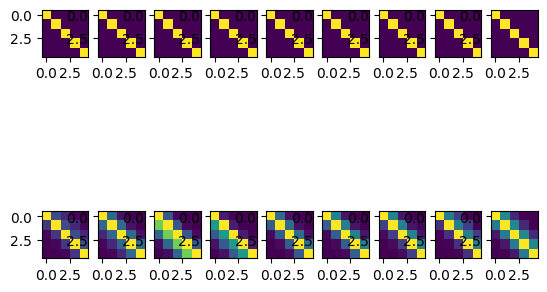

In [13]:
def active_inference_basic_1D(hyperparameters,constants):
    a0,b0,c0,d0,e0,u = basic_latent_model({**constants, **hyperparameters})
    beta = hyperparameters["action_selection_temperature"]
    
    planning_options = get_planning_options(constants["Th"],"classic",a_novel=False,b_novel=False)
    learning_options = get_learning_options(learn_b=True,lr_b=hyperparameters["transition_learning_rate"],method="vanilla+backwards",
                                    state_generalize_function=lambda x : jnp.exp(-hyperparameters["state_interpolation_temperature"]),
                                    action_generalize_table=None,
                                    cross_action_extrapolation_coeff=None)
    # ____________________________________________________________________________________________
    # Each agent is a set of functions of the form :    
    def initial_params():
        # The initial parameters of the AIF agent are its model weights :
        return a0,b0,c0,d0,e0,u
    
    def initial_state(params):
        pa,pb,pc,pd,pe,u = params

        # The "states" of the active Inference agent are : 
        # 1. The vectorized parameters for this trial :
        trial_a,trial_b,trial_d = vectorize_weights(pa,pb,pd,u)
        trial_c,trial_e = to_log_space(pc,pe)
        trial_a_nov,trial_b_nov = get_vectorized_novelty(pa,pb,u,compute_a_novelty=True,compute_b_novelty=True)
        
        # 2. Its priors about the next state : (given by the d matrix parameter)
        prior = trial_d
        
        return prior,jnp.zeros_like(trial_d),(trial_a,trial_b,trial_c,trial_e,trial_a_nov,trial_b_nov) # We don't need trial_d anymore !

    def actor_step(observation,state,params,rng_key):
        emission,reward,trial_over,t = observation
        gauge_level = emission[0]
                
        state_prior,_,timestep_weights = state
        a_norm,b_norm,c,e,a_novel,b_novel = timestep_weights
        
        end_of_trial_filter = jnp.ones((planning_options["horizon"]+2,))
        qs,F,raw_qpi,efe = compute_step_posteriors(t,state_prior,emission,a_norm,b_norm,c,e,a_novel,b_novel,
                                    end_of_trial_filter,
                                    rng_key,planning_options)       

        # Action selection :        
        action_distribution = jax.nn.softmax(beta*efe)
        action_selected = jr.categorical(rng_key,_jaxlog(action_distribution))
        vect_action_selected = jax.nn.one_hot(action_selected,action_distribution.shape[0])  
        
        # New state prior : 
        new_prior = jnp.einsum("iju,j,u->i",b_norm,qs,vect_action_selected)
        
        # OPTIONAL : ONLINE UPDATING OF PARAMETERS 
        
        return (new_prior,qs,timestep_weights),(action_distribution,action_selected,vect_action_selected)


    def update_params(trial_history,params):
        pa,pb,pc,pd,pe,u = params
        rewards,observations,states,actions = trial_history
        
        _,posteriors_history,_ = states   
        
        print(posteriors_history)

        obs_vect_arr = [jnp.array(observations[0])]
        qs_arr = jnp.stack(posteriors_history)
        u_vect_arr = jnp.stack(actions)    
        
        # Then, we update the parameters of our HMM model at this level
        # We use the raw weights here !
        a_post,b_post,c_post,d_post,e_post,qs_post = learn_after_trial(obs_vect_arr,qs_arr,u_vect_arr,
                                                pa,pb,c,pd,e,u,
                                                method = learning_options["method"],
                                                learn_what = learning_options["bool"],
                                                learn_rates = learning_options["rates"],
                                                generalize_state_function=learning_options["state_generalize_function"],
                                                generalize_action_table=learning_options["action_generalize_table"],
                                                cross_action_extrapolation_coeff=learning_options["cross_action_extrapolation_coeff"],
                                                em_iter = learning_options["em_iterations"])
        
        # The params for the next step is the last choice kernel of the trial :
        # (the update already occured during the actor step !)
        return a_post,b_post,c_post,d_post,e_post,u
    # ____________________________________________________________________________________________
    
    return initial_params,initial_state,actor_step,update_params







# We get a model weights by defining a "parameters" object :
aif_1d_constants = {
    # General environment : 
    "N_feedback_ticks":N_FEEDBACK_OUTCOMES,
    # Latent state space structure
    "Ns_latent":5,      # For 1D
    # Action discretization:
    "N_actions_distance" :3,
    "N_actions_position" :9,
    "N_actions_angle" :9,
    
    "Th" : 3
}

aif_1d_params = {    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration": 1.0,
    "transition_stickiness": 1.0,
    "transition_learning_rate" : 1.0,
    "state_interpolation_temperature" : 1.0,
    
    "initial_state_concentration": 1.0,
    
    "feedback_expected_std" : 0.15,
    "emission_concentration" : 1.0,
    "emission_stickiness" : 100.0,
    
    "reward_seeking" : 10.0,
    
    "action_selection_temperature" : 1.0,
}

a0,b0,c0,d0,e0,u = basic_latent_model({**aif_1d_constants, **aif_1d_params})
params_final,training_hist = run_loop(env,active_inference_basic_1D(aif_1d_params,aif_1d_constants),SEED,NTRIALS)

a,b,c,d,e,u = params_final


nu = u.shape[0]


fig,axs = plt.subplots(2,nu)
print(b)
for act in range(nu):
    ax = axs[0,act]
    ax.imshow(b0[0][...,act])
    
    ax = axs[1,act]
    ax.imshow(b[0][...,act])



Nice, we have all of our proposal models.  However, we aim at performing model inversion based on task data ! This means that we're going to need **likelihood functions** for each of these models !

Likelihood function describe the probability of these models generating the observed actions, given their hyperparameters $\theta$ and their previous experiences $o_{1:T,1:t},s_{1:T,1:t}$ : 
$$
\sum_T \sum_{t\in T} P(u_t|o_{1:T,1:t},u_{1:T,1:t-1},\theta)
$$

In the next notebook, we'll derive these functions from the models shown here !